# Photoacclimation

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker
from matplotlib.colors import TwoSlopeNorm
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
from scipy import stats

In [2]:
import os
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

USER = os.environ['USER']

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster = PBSCluster(
    cores=1,
    memory='25GB', #25
    processes=1,
    queue='casper',
    local_directory=f'/glade/scratch/{USER}/dask-workers',
    log_directory=f'/glade/scratch/{USER}/dask-workers',
    resource_spec='select=1:ncpus=1:mem=25GB',
    project='P93300070',
    walltime='03:00:00',
    interface='ib0')

client = Client(cluster)
# cluster.adapt(minimum_jobs=0, maximum_jobs=24)
cluster.scale(10) # use when running climatology calculations
client

/glade/work/gclow/conda-envs/my-npl-ml/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38247 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/38247/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/38247/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.39:35316,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gclow/Batch/proxy/38247/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
from sklearn.linear_model import LinearRegression

def calc_linear_regression(x, y):
    stacked = np.column_stack((x.flatten(), y.flatten()))
    stacked = stacked[~np.isnan(stacked).any(axis=1)]
    
    x_new = stacked[:,0].reshape((-1, 1))
    y_new = stacked[:,1]
    if y_new.shape[0] < 10:
        return np.nan
    else: 
        model = LinearRegression().fit(x_new, y_new)
        r_sq = model.score(x_new, y_new)
        #slope = model.coef_
        return r_sq # slope

def calc_pearson_corr(x, y):
    stacked = np.column_stack((x.flatten(), y.flatten()))
    stacked = stacked[~np.isnan(stacked).any(axis=1)]
    if stacked.shape[0] < 10:
        return np.nan
    else:
        corr, p_val = stats.pearsonr(stacked[:,0], stacked[:,1])
        return corr

# Import Data

In [5]:
TAREA = xr.open_dataset('/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.0001-01-01.nc').TAREA

In [6]:
biomes = xr.open_dataset('../data/biomes_regrid_pop.nc')

In [7]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/daily/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.ecosys.nday1.'
data = xr.open_mfdataset(base+'*.nc', concat_dim="time", parallel = True, chunks = {'time':365},
                              data_vars='minimal', compat='override', 
                              coords='minimal')
data

<xarray.Dataset>
Dimensions:                     (time: 10950, nlat: 384, nlon: 320)
Coordinates:
  * time                        (time) object 0020-01-01 00:00:00 ... 0049-12...
    ULONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables: (12/14)
    totChl                      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_sat_nocld_wgt        (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp_wgt            (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_isccp                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis                (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    ...                          ...
    totChl_sat_nocld_wgt_swath  (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_swath          (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    totChl_modis_wgt_swath      (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_modis             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_isccp             (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>
    cloudfrac_wgt               (time, nlat, nlon) float32 dask.array<chunksize=(365, 384, 320), meta=np.ndarray>

In [8]:
data_monthly = data.resample(time='M', label='right').mean(dim='time')
data_monthly['time'] = data_monthly.time + pd.Timedelta(days=1)

In [9]:
# Use clouds from POP because this will only include daylight regions in correlations
clouds_mean = (data_monthly.cloudfrac_isccp/data_monthly.cloudfrac_wgt).groupby("time.month").mean(dim='time').compute()
cloud_anom = ((data_monthly.cloudfrac_isccp/data_monthly.cloudfrac_wgt).groupby("time.month") - clouds_mean).compute()

In [10]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.'

years = range(20,50) 
months = range(1,13)
files = []

var_list = ['sp_N_lim_surf', 'sp_P_lim_surf', 'sp_Fe_lim_surf','sp_light_lim_surf', 
            'sp_light_lim_Cweight_avg_100m', 'spC', 'spChl',
            'diat_N_lim_surf', 'diat_P_lim_surf', 'diat_Fe_lim_surf', 
            'diat_light_lim_surf', 'diat_SiO3_lim_surf', 'diat_light_lim_Cweight_avg_100m',
            'diatChl', 'diatC'] 

for year in years: 
    for month in months:  
        files.append(base+'00{0}-{1}.nc'.format(year, str(month).zfill(2)))

ecosys_data = xr.open_mfdataset(files, concat_dim="time", parallel = True,
                              data_vars='minimal', compat='override', coords='minimal')

ecosys_data = ecosys_data[var_list]

In [11]:
base = '/glade/scratch/gclow/archive/b.e22.B1850.f09_g17.cosp_chlor_30yr/ocn/hist/b.e22.B1850.f09_g17.cosp_chlor_30yr.pop.h.nday1.'

years = range(20,50) 
months = range(1,13)
files = []

for year in years: 
    for month in months:  
        files.append(base+'00{0}-{1}-01.nc'.format(year, str(month).zfill(2)))

phys_oc_data = xr.open_mfdataset(files, concat_dim="time", parallel = True,
                              data_vars='minimal', compat='override', coords='minimal')

phys_oc_data = phys_oc_data[['SST', 'SSS', 'HMXL_DR_2']]

In [12]:
phys_oc_data_monthly = phys_oc_data.resample(time='M').mean(dim='time')
climo = phys_oc_data_monthly.groupby("time.month").mean(dim='time').compute()
phys_oc_data_anom = (phys_oc_data_monthly.groupby("time.month") - climo).compute()

# How do clouds impact light limitation and photoacclimation?

For each month, do a spatial correlation between cloud and light limitation anomalies

What other factors impact light limitation?
- sea ice
- clouds
- sediment
- blooms
- mixed layer depth (but this shouldn't impact surface)

## Small Phytoplankton

In [13]:
sp_light_lim_monthly_mean = ecosys_data.sp_light_lim_Cweight_avg_100m.groupby('time.month').mean(dim='time').compute()
sp_light_lim_monthly_anom = (ecosys_data.sp_light_lim_Cweight_avg_100m.groupby("time.month") - sp_light_lim_monthly_mean).compute()

In [18]:
sp_theta = (ecosys_data.spChl/ecosys_data.spC).isel(z_t_150m=0)
sp_theta_mean = sp_theta.groupby('time.month').mean(dim='time').compute()
sp_theta_anom = (sp_theta.groupby("time.month") - sp_theta_mean).compute()

### Correlation in time

Text(0.5, 1.0, 'SP Clouds & Light Lim Corr.')

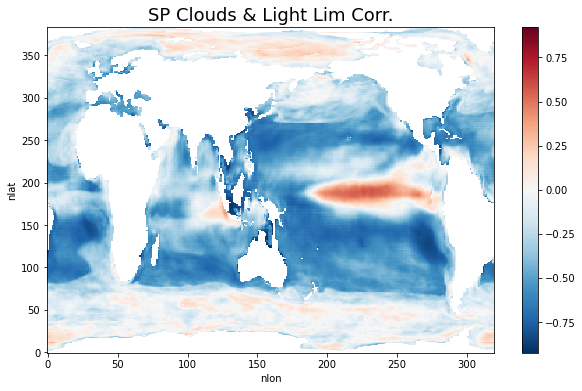

In [42]:
# Correlation between clouds and light limitation

corr_monthly_ligh_lim = xr.apply_ufunc(
    calc_pearson_corr,  # function
    cloud_anom, 
    sp_light_lim_monthly_anom,
    input_core_dims=[["time"], ["time"]], 
    vectorize=True,
)
corr_monthly_ligh_lim.plot(figsize = (10,6))
plt.title('SP Clouds & Light Lim Corr.', fontsize = 18)

Light lim: High clouds = more light limitation (lower values).
In red regions, higher clouds = less light limitation. Could this be related to changes in mixed layer depth. In the eastern equatorial Pacific, La Nina = lower clouds & shallower mixed layer depth (elevated thermocline), so less light limitation?

Text(0.5, 1.0, 'SP Clouds & Theta Corr.')

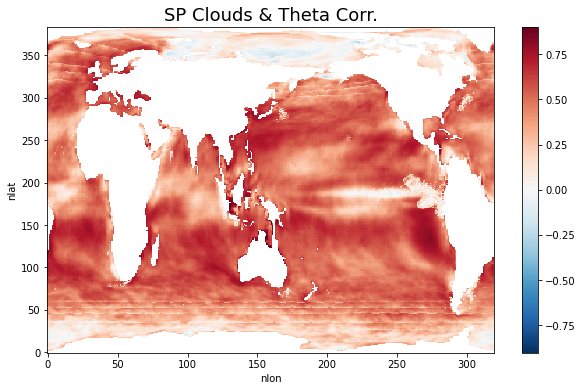

In [43]:
# Correlation between clouds and theta (Chl:C)

corr_monthly = xr.apply_ufunc(
    calc_pearson_corr,  # function
    cloud_anom, 
    sp_theta_anom,
    input_core_dims=[["time"], ["time"]], 
    vectorize=True)

corr_monthly.plot(figsize = (10,6))
plt.title('SP Clouds & Theta Corr.', fontsize = 18)

Theta (pigmentation): High clouds = high pigmentation. Positive almost everywhere except for very high latitudes. The correlation with clouds is lower in the cloudy regions (high latitudes and equator)

### Correlation in space

In [44]:
#biome_means_df = pd.read_csv('biome_spatial_corr.csv')
biome_means_df = pd.DataFrame()

for biome in range(1,18):
    print(biome)
    mask = (biomes.MeanBiomes==biome)
    
    for month in range(1,13):
        
        clouds = clouds_mean.sel(month=month).where(mask)
        theta = sp_theta_mean.sel(month=month).where(mask)
        sp_light_lim = sp_light_lim_monthly_mean.sel(month=month).where(mask)
        
        stacked = np.column_stack((clouds.to_numpy().flatten(), theta.to_numpy().flatten(), sp_light_lim.to_numpy().flatten()))
        stacked = stacked[~np.isnan(stacked).any(axis=1)]
        
        if stacked.shape[0] < 10:
            theta_corr = np.nan
            theta_p_val = np.nan
            light_corr = np.nan
            light_p_val = np.nan
        
        else: 
            theta_corr, theta_p_val = stats.pearsonr(stacked[:,0], stacked[:,1])
            light_corr, light_p_val = stats.pearsonr(stacked[:,0], stacked[:,2])
        
        df_new = pd.DataFrame(data = {'biome': [biome], 'month': [month],  
                                      'theta_corr': [theta_corr], 'theta_p_val': [theta_p_val], 
                                      'light_corr': [light_corr], 'light_p_val': [light_p_val],})

        biome_means_df = pd.concat([biome_means_df, df_new])
        # biome_means_df.to_csv('../data/biome_spatial_corr_pearson.csv')
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Text(0.5, 1.0, 'SP Clouds & Light Lim Corr.')

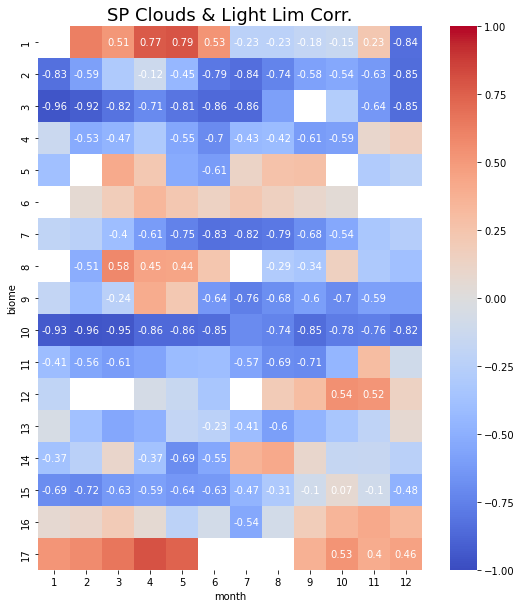

In [45]:
light_biome_corr_matrix = pd.pivot(biome_means_df, index='biome', columns='month', values='light_corr')
light_biome_corr_matrix = light_biome_corr_matrix.round(2)
pval_matrix = pd.pivot(biome_means_df, index='biome', columns='month', values='light_p_val')

pval_mask = (pval_matrix>0.05)
strong_corr_mask = (abs(biome_corr_matrix)<0.5)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    light_biome_corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True, annot=False, 
    mask=pval_mask
)

ax = sns.heatmap(
    light_biome_corr_matrix, cbar = False,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm', alpha = 0,
    square=True, annot=True, 
    annot_kws = {'color':'white'},
    mask=strong_corr_mask
)

plt.title('SP Clouds & Light Lim Corr.', fontsize = 18)

Text(0.5, 1.0, 'SP Clouds & Theta Corr.')

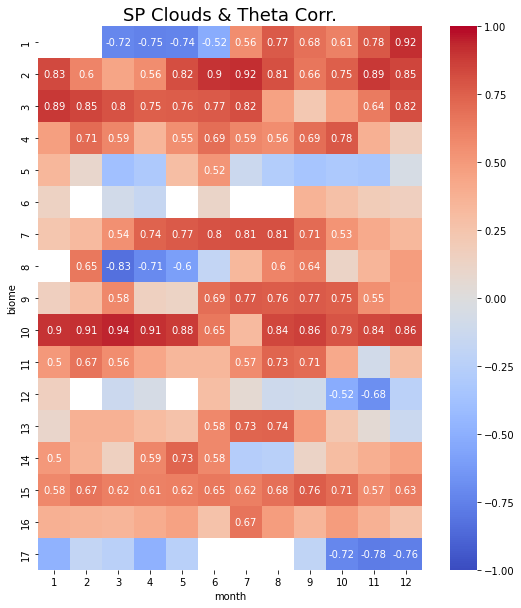

In [46]:
theta_biome_corr_matrix = pd.pivot(biome_means_df, index='biome', columns='month', values='theta_corr')
theta_biome_corr_matrix = theta_biome_corr_matrix.round(2)
pval_matrix = pd.pivot(biome_means_df, index='biome', columns='month', values='theta_p_val')

pval_mask = (pval_matrix>0.05)
strong_corr_mask = (abs(biome_corr_matrix)<0.5)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    theta_biome_corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True, annot=False, 
    mask=pval_mask
)

ax = sns.heatmap(
    theta_biome_corr_matrix, cbar = False,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm', alpha = 0,
    square=True, annot=True, 
    annot_kws = {'color':'white'},
    mask=strong_corr_mask
)

plt.title('SP Clouds & Theta Corr.', fontsize = 18)

## Diatoms

In [47]:
diat_light_lim_monthly_mean = ecosys_data.diat_light_lim_Cweight_avg_100m.groupby('time.month').mean(dim='time').compute()
diat_light_lim_monthly_anom = (ecosys_data.diat_light_lim_Cweight_avg_100m.groupby("time.month") - sp_light_lim_monthly_mean).compute()

In [29]:
diat_theta = (ecosys_data.diatChl/ecosys_data.diatC).isel(z_t_150m=0)
diat_theta_mean = diat_theta.groupby('time.month').mean(dim='time').compute()
diat_theta_anom = (diat_theta.groupby("time.month") - diat_theta_mean).compute()

### Correlation in time

Text(0.5, 1.0, 'Diat Clouds & Light Lim Corr.')

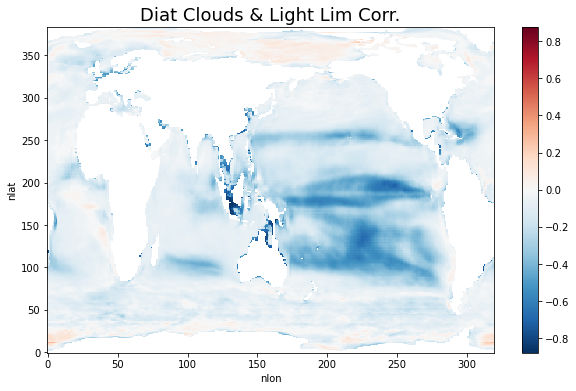

In [48]:
# Correlation between clouds and light limitation

corr_monthly_ligh_lim = xr.apply_ufunc(
    calc_pearson_corr,  # function
    cloud_anom, 
    diat_light_lim_monthly_anom,
    input_core_dims=[["time"], ["time"]], 
    vectorize=True,
)
corr_monthly_ligh_lim.plot(figsize = (10,6))

plt.title('Diat Clouds & Light Lim Corr.', fontsize = 18)

Light lim: High clouds = more light limitation (lower values). Overall, lower correlations than small phytoplankton.

Text(0.5, 1.0, 'Diat Clouds & Theta Corr.')

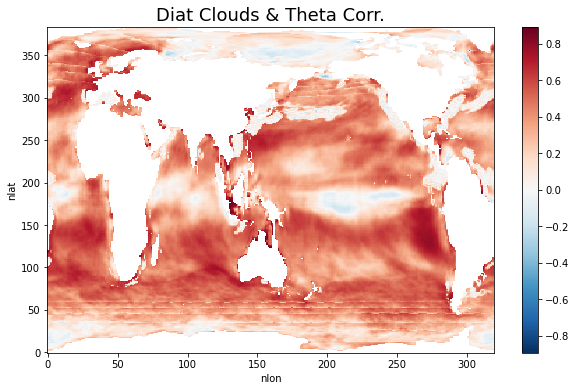

In [50]:
# Correlation between clouds and theta (Chl:C)

corr_monthly = xr.apply_ufunc(
    calc_pearson_corr,  # function
    cloud_anom, 
    diat_theta_anom,
    input_core_dims=[["time"], ["time"]], 
    vectorize=True)

corr_monthly.plot(figsize = (10,6))

plt.title('Diat Clouds & Theta Corr.', fontsize = 18)

Theta (pigmentation): High clouds = high pigmentation. Positive almost everywhere except for very high latitudes and equatorial Pacific.

### Correlation in space

In [51]:
#biome_means_df = pd.read_csv('biome_spatial_corr.csv')
diat_biome_means_df = pd.DataFrame()

for biome in range(1,18):
    print(biome)
    mask = (biomes.MeanBiomes==biome)
    
    for month in range(1,13):
        
        clouds = clouds_mean.sel(month=month).where(mask)
        theta = diat_theta_mean.sel(month=month).where(mask)
        diat_light_lim = diat_light_lim_monthly_mean.sel(month=month).where(mask)
        
        stacked = np.column_stack((clouds.to_numpy().flatten(), theta.to_numpy().flatten(), diat_light_lim.to_numpy().flatten()))
        stacked = stacked[~np.isnan(stacked).any(axis=1)]
        
        if stacked.shape[0] < 10:
            theta_corr = np.nan
            theta_p_val = np.nan
            light_corr = np.nan
            light_p_val = np.nan
        
        else: 
            theta_corr, theta_p_val = stats.pearsonr(stacked[:,0], stacked[:,1])
            light_corr, light_p_val = stats.pearsonr(stacked[:,0], stacked[:,2])
        
        df_new = pd.DataFrame(data = {'biome': [biome], 'month': [month],  
                                      'theta_corr': [theta_corr], 'theta_p_val': [theta_p_val], 
                                      'light_corr': [light_corr], 'light_p_val': [light_p_val],})

        diat_biome_means_df = pd.concat([diat_biome_means_df, df_new])
        # biome_means_df.to_csv('../data/biome_spatial_corr_pearson.csv')
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Text(0.5, 1.0, 'Diat Clouds & Light Lim Corr.')

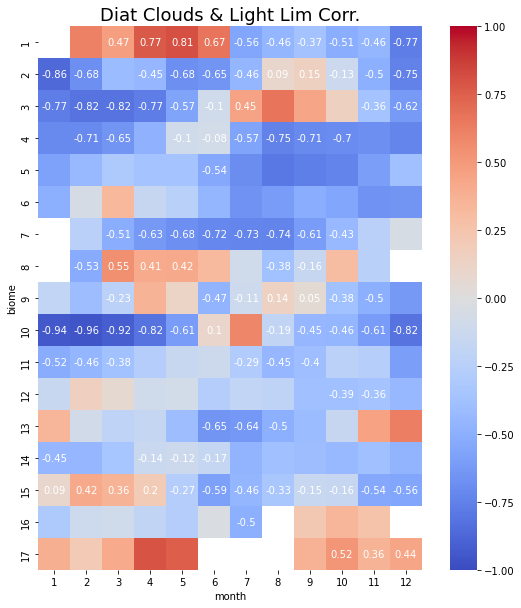

In [52]:
light_biome_corr_matrix = pd.pivot(diat_biome_means_df, index='biome', columns='month', values='light_corr')
light_biome_corr_matrix = light_biome_corr_matrix.round(2)
pval_matrix = pd.pivot(diat_biome_means_df, index='biome', columns='month', values='light_p_val')

pval_mask = (pval_matrix>0.05)
strong_corr_mask = (abs(biome_corr_matrix)<0.5)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    light_biome_corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True, annot=False, 
    mask=pval_mask
)

ax = sns.heatmap(
    light_biome_corr_matrix, cbar = False,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm', alpha = 0,
    square=True, annot=True, 
    annot_kws = {'color':'white'},
    mask=strong_corr_mask
)

plt.title('Diat Clouds & Light Lim Corr.', fontsize = 18)

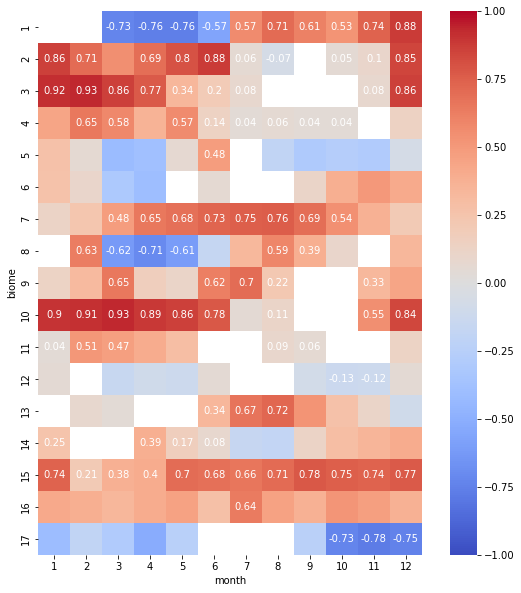

In [34]:
theta_biome_corr_matrix = pd.pivot(diat_biome_means_df, index='biome', columns='month', values='theta_corr')
theta_biome_corr_matrix = theta_biome_corr_matrix.round(2)
pval_matrix = pd.pivot(diat_biome_means_df, index='biome', columns='month', values='theta_p_val')

pval_mask = (pval_matrix>0.05)
strong_corr_mask = (abs(biome_corr_matrix)<0.5)

plt.figure(figsize=(10,10))
ax = sns.heatmap(
    theta_biome_corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True, annot=False, 
    mask=pval_mask
)

ax = sns.heatmap(
    theta_biome_corr_matrix, cbar = False,
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm', alpha = 0,
    square=True, annot=True, 
    annot_kws = {'color':'white'},
    mask=strong_corr_mask
)

plt.title('Diat Clouds & Theta Corr.', fontsize = 18)

## Investigate differences between small phytoplankton and diatoms

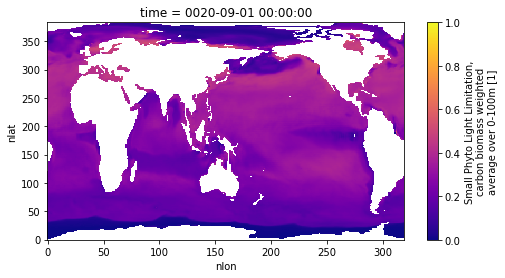

In [155]:
ecosys_data.sp_light_lim_Cweight_avg_100m.isel(time=7).plot(figsize = (8,4), vmin = 0, vmax = 1, cmap = 'plasma')

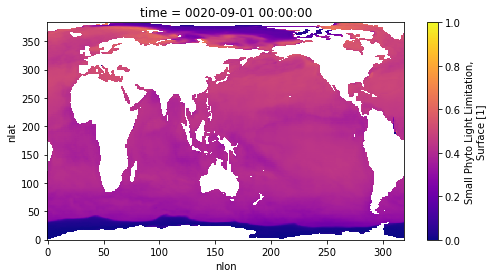

In [151]:
ecosys_data.sp_light_lim_surf.isel(time=7).plot(figsize = (8,4), vmin = 0, vmax = 1, cmap = 'plasma')

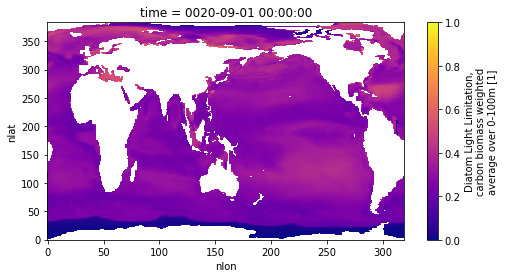

In [156]:
ecosys_data.diat_light_lim_Cweight_avg_100m.isel(time=7).plot(figsize = (8,4), vmin = 0, vmax = 1, cmap = 'plasma')

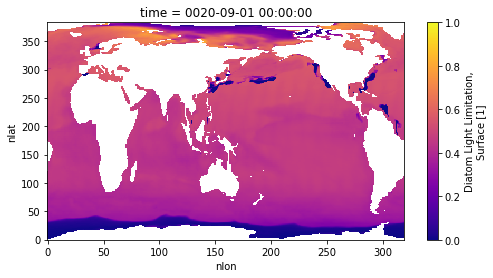

In [150]:
ecosys_data.diat_light_lim_surf.isel(time=7).plot(figsize = (8,4), vmin = 0, vmax = 1, cmap = 'plasma')